In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from random import randrange 
import time

In [2]:
# clean memory from figures created using plt.figure in previous sessions

plt.show(block=False); time.sleep(5); plt.close('all')
#plt.get_fignums()

In [3]:
class Image_Warping():
    
    def __init__(self,image_path = "McS9K.png", N = 1, circle_radius = 25):
        self.path = image_path
        self.N = N
        self.radius = circle_radius
        
        self.plot = True
        self.img, self.image_shape = self.image_loader()
        self.A = self.get_motions_models()
        self.alpha_maps = self.get_alpha_maps()
        self.rgb_layers = self.get_rgb_layers()
        self.flow_x,self.flow_y, self.pixel_x, self.pixel_y = self.get_optical_flow(self.A)
        self.new_pixel_x, self.new_pixel_y = self.get_new_pixels()
        self.warped_rgb_layer = self.get_warped_rgb_layer()
        self.warped_rgb_layers = self.get_warped_layers()
        warped_image = self.get_warped_image()
        
        pass

    def image_loader(self, plot = True):
        '''load image'''
        img = Image.open(self.path)
        img = np.asarray(img).copy()

        image_shape = img.shape
        if plot == True:
            plt.figure()
            plt.imshow(img)
            plt.title("Original Image")
            plt.show()
        
        return img, image_shape

    def get_motions_models(self, round = True, scale = 1):

        '''create N random affine motions'''
        A = np.empty((self.N,2,3))*scale

        for i in range(self.N):
        

            model = np.random.rand(2,3)
            model = np.round(model) if round == True else model
            if self.N == 1:
                A = model
            elif self.N > 1:
                A[i,:,:] = model

        return A 

    def get_alpha_maps(self, plot = True):

        '''create N  alpha maps with shape of a circle'''
        
        R = self.radius
        offset = round(R * 2.1)
        x_lim = self.image_shape[1]/2
        y_lim = self.image_shape[0]/2
        
        x_lim = round(x_lim)
        y_lim = round(y_lim)

        
        alpha_maps = []
        for _ in range(self.N):
            mask = np.zeros(self.image_shape)
            alpha_map = cv2.circle(mask,(randrange(R,x_lim-R, offset),randrange(R,y_lim-R, offset)),R,(1,1,1),-1)
            if self.N == 1:
                alpha_maps = alpha_map    
            elif self.N > 1:
                alpha_maps.append(alpha_map)
                
            if plot == True:
                plt.figure()
                plt.imshow(alpha_map)
                plt.title("Alpha map")
                plt.show()
            
        return alpha_maps

    def get_rgb_layers(self, plot = True):

        '''take alpha maps as input, output rgb layers '''

        rgb_layers = []
        
        for i in range(self.N):
            rgb_layer = self.img.copy()
            
            if self.N == 1:
                rgb_layer[self.alpha_maps == 0] = 0 
                rgb_layers = rgb_layer

            elif self.N > 1:
                rgb_layer[self.alpha_maps[i] == 0] = 0 
                rgb_layers.append(rgb_layer)
            
            if plot:
                plt.figure()
                plt.imshow(rgb_layer)
                plt.title("RGB layer")
                plt.show()

        return rgb_layers
    
    def get_optical_flow(self, A, round = True):

        
        pixel_x, pixel_y = np.where(self.rgb_layers[:,:,0] != 0)
        #print(type(pixel_x),type(pixel_y))
        flow_x = np.zeros((self.rgb_layers.shape[0], self.rgb_layers.shape[1])) 
        flow_y = flow_x

        for i,j in zip(pixel_x,pixel_y):
            
            u_x, u_y = np.matmul(A,np.array([1,i,j]))
            
            flow_x[i,j] = u_x
            flow_y[i,j] = u_y
            
        flow = np.stack((flow_x,flow_y), axis = 0)   # flow_x = flow[0,:,:]; flow_y = flow[1,:,:]


        return flow_x,flow_y, pixel_x, pixel_y

    def get_new_pixels( self, round = True):
        
        new_pixel_x = self.pixel_x + self.flow_x[self.pixel_x,self.pixel_y]
        new_pixel_y = self.pixel_y + self.flow_y[self.pixel_x,self.pixel_y]
        
        new_pixel_x = np.round(new_pixel_x).astype(int) if round == True else new_pixel_x
        new_pixel_y = np.round(new_pixel_y).astype(int) if round == True else new_pixel_y
            
        return new_pixel_x, new_pixel_y 
    
    def get_warped_rgb_layer(self):
        
        warped_rgb_layer = np.zeros_like(self.rgb_layers)
        warped_rgb_layer[self.new_pixel_x,self.new_pixel_y,:] = self.rgb_layers[self.pixel_x,self.pixel_y,:]
        return warped_rgb_layer

    def get_warped_layers(self, plot = True):
        '''take as input the rgb layers, motion models, and alpha maps, output the warped rgb layers'''
        warped_rgb_layers = []
        
        for i in range(self.N):
            if self.N ==1:
                self.flow_x,self.flow_y, self.pixel_x, self.pixel_y = self.get_optical_flow(self.A)
                new_pixel_x, new_pixel_y = self.get_new_pixels()
                warped_rgb_layer = self.get_warped_rgb_layer()
                warped_rgb_layers = warped_rgb_layer
                
            elif self.N > 1:
                flow_x, flow_y, pixel_x, pixel_y = self.get_optical_flow(self.A[i,:,:],self.rgb_layers[i]) 
                new_pixel_x, new_pixel_y = self.get_new_pixels(pixel_x, pixel_y, flow_x, flow_y)
                warped_rgb_layer = self.get_warped_rgb_layer(self.rgb_layers[i], new_pixel_x, new_pixel_y, pixel_x, pixel_y)
                warped_rgb_layers.append(warped_rgb_layer)
            
            if plot:
                plt.figure()
                plt.imshow(warped_rgb_layer)
                plt.title("Warped RGB layer")
                plt.show()

        return warped_rgb_layers
    
    def get_warped_image(self):
        '''take as input the warped rgb layers, output the warped image'''
        warped_image = self.img.copy()
        plt.figure()
        for i in range(self.N):
            if self.N == 1:
                warped_image[self.warped_rgb_layers != 0] = self.warped_rgb_layers[self.warped_rgb_layers != 0]
                break
            elif self.N > 1:
                warped_image[self.warped_rgb_layers[i] != 0] = self.warped_rgb_layers[i][self.warped_rgb_layers[i] != 0]
        plt.imshow(warped_image)
        return warped_image

In [ ]:
if __name__ == "__main__" :

    obj = Image_Warping()
    warped_image = obj.get_warped_image()

In [5]:

def image_loader(path, plot = True):
    '''
    load image
    '''
    img = Image.open(path)
    img = np.asarray(img).copy()
    image_shape = img.shape
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.title("Original image")
        plt.show()
    return img, image_shape

def get_motions_models(N, round = True, scale = 1):

    '''create N random affine motions'''
    A = np.empty((N,2,3))*scale

    for i in range(N):
    
        model = np.random.rand(2,3)
        model = np.round(model) if round == True else model
        if N == 1:
            A = model
        elif N > 1:
            A[i,:,:] = model

    return A 

def get_alpha_maps(N,image_shape, plot = True):
    ''' create N random alpha maps with shape of a circle'''
    
    radius = 25
    offset = round(radius * 2.1)
    x_lim = image_shape[1]/2
    y_lim = image_shape[0]/2
    
    alpha_maps = []
    for _ in range(N):
        mask = np.zeros(image_shape)
        alpha_map = cv2.circle(mask,(randrange(radius,round(x_lim)-radius, offset),randrange(radius,round(y_lim)-radius, offset)),radius,(1,1,1),-1)
        if N == 1:
            alpha_maps = alpha_map
            
        elif N > 1:
            alpha_maps.append(alpha_map)
        
        if plot:
            plt.figure()
            plt.imshow(alpha_map)
            plt.title("Alpha map")
            plt.show()
         
    return alpha_maps

def get_rgb_layers(N,alpha_maps,img, plot = True):
    '''take alpha maps as input, output rgb layers '''
    rgb_layers = []
    
    for i in range(N):
        rgb_layer = img.copy()
        if N == 1:
            rgb_layer[alpha_maps == 0] = 0 
            rgb_layers = rgb_layer
            
            
        elif N > 1:
            rgb_layer[alpha_maps[i] == 0] = 0 
            rgb_layers.append(rgb_layer)
            plt.figure()
            plt.imshow(rgb_layer)
        
        if plot:
            plt.figure()
            plt.imshow(rgb_layer)
            plt.title("RGB layer")
            plt.show()
        
    return rgb_layers 

def get_optical_flow(A,rgb_layer, round = True):

    '''take as input the motion model and the rgb layer, output optic flow according to that rgb layer'''
    pixel_x, pixel_y = np.where(rgb_layer[:,:,0] != 0)
    flow_x = np.zeros((rgb_layer.shape[0], rgb_layer.shape[1])) 
    flow_y = flow_x
    
    for i,j in zip(pixel_x,pixel_y):
        
        u_x, u_y = np.matmul(A,np.array([1,i,j]))
        
        flow_x[i,j] = u_x
        flow_y[i,j] = u_y
        
    flow = np.stack((flow_x,flow_y), axis = 0)   # flow_x = flow[0,:,:]; flow_y = flow[1,:,:]

    
    return flow_x,flow_y, pixel_x, pixel_y

def get_new_pixels(pixel_x, pixel_y, flow_x, flow_y, round = True):
    '''take as input the pixel coordinates and the flow, output the new pixel coordinates'''
    new_pixel_x = pixel_x + flow_x[pixel_x,pixel_y]
    new_pixel_y = pixel_y + flow_y[pixel_x,pixel_y]
    print(new_pixel_x)
    new_pixel_x = np.round(new_pixel_x).astype(int) if round == True else new_pixel_x
    new_pixel_y = np.round(new_pixel_y).astype(int) if round == True else new_pixel_y
        
    return new_pixel_x, new_pixel_y   

def get_warped_rgb_layer(rgb_layer, new_pixel_x, new_pixel_y, pixel_x, pixel_y):
    '''take as input the rgb layer, new pixel coordinates, and old pixel coordinates, output the warped rgb layer'''
    warped_rgb_layer = np.zeros_like(rgb_layer)
    warped_rgb_layer[new_pixel_x,new_pixel_y,:] = rgb_layer[pixel_x,pixel_y,:]
    return warped_rgb_layer

def get_warped_layers(N, rgb_layers, A, alpha_layers, plot = True):
    '''take as input the rgb layers, motion models, and alpha maps, output the warped rgb layers'''
    warped_rgb_layers = []
    
    for i in range(N):
        if N ==1:
            flow_x,flow_y, pixel_x, pixel_y = get_optical_flow(A,rgb_layers)
            new_pixel_x, new_pixel_y = get_new_pixels(pixel_x, pixel_y, flow_x, flow_y)
            warped_rgb_layer = get_warped_rgb_layer(rgb_layers, new_pixel_x, new_pixel_y, pixel_x, pixel_y)
            warped_rgb_layers = warped_rgb_layer
        elif N > 1:
            flow_x, flow_y, pixel_x, pixel_y = get_optical_flow(A[i,:,:],rgb_layers[i]) 
            new_pixel_x, new_pixel_y = get_new_pixels(pixel_x, pixel_y, flow_x, flow_y)
            warped_rgb_layer = get_warped_rgb_layer(rgb_layers[i], new_pixel_x, new_pixel_y, pixel_x, pixel_y)
            warped_rgb_layers.append(warped_rgb_layer)
            
        if plot:
            plt.figure()
            plt.imshow(warped_rgb_layer)
            plt.title("Warped rgb layer")
            plt.show()
    return warped_rgb_layers

def get_warped_image(N, warped_rgb_layers,img, plot = True):
    '''take as input the warped rgb layers, output the warped image'''
    warped_image = img.copy()
    
    for i in range(N):
        if N == 1:
            warped_image[warped_rgb_layers != 0] = warped_rgb_layers[warped_rgb_layers != 0]
            break
        elif N > 1:
            warped_image[warped_rgb_layers[i] != 0] = warped_rgb_layers[i][warped_rgb_layers[i] != 0]
    if plot:
        plt.figure()
        plt.imshow(warped_image)
        plt.title("Warped image")
        plt.show()   
    return warped_image

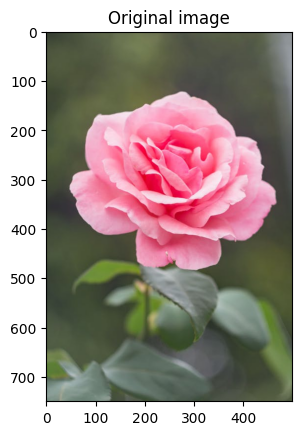

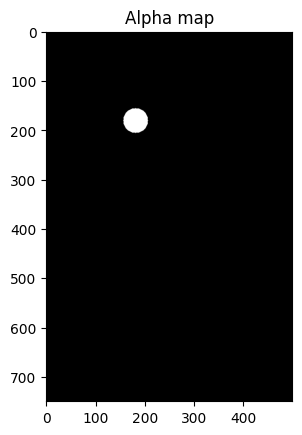

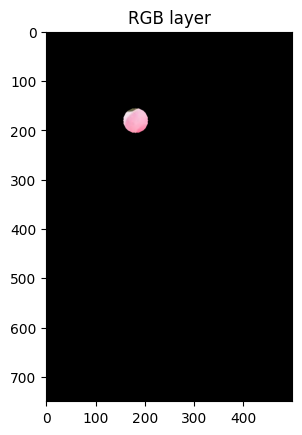

In [7]:
N = 1
img, image_shape = image_loader("image_folder/McS9K.png")
alpha_layers = get_alpha_maps(N, image_shape)
rgb_layers = get_rgb_layers(N,alpha_layers,img.copy())

In [16]:
A = get_motions_models(N, round = False, scale = 1)

[340.10004009 341.23131072 341.25399047 ... 403.44753407 403.47021382
 404.60148445]


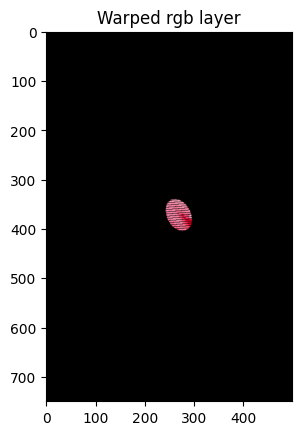

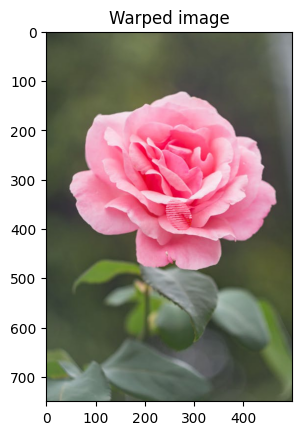

In [19]:
warped_rgb_layers = get_warped_layers(N, rgb_layers, A, alpha_layers)
warped_image = get_warped_image(N, warped_rgb_layers,img)